# Train using mini-batch SGD, multiple records used to compute gradient

This notebook is part of article [Explaining RNNs without neural networks](https://explained.ai/rnn/index.html) and notebook [prep.ipynb](prep.ipynb) should be run before this notebook as it needs files: `data/X.pkl` and `data/y.pkl`.

Still w/o vectorization, we train one full record at a time; we just do a batch of words before computing gradients.

## Load X, y

In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

!if ! test -f support.py; then wget https://raw.githubusercontent.com/parrt/ml-articles/master/rnn/notebooks/support.py; fi

from support import *

In [2]:
import pickle
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)
with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

## Split out validation set

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

In [4]:
def forward1(x):
    h = torch.zeros(nhidden, 1, dtype=torch.float64, requires_grad=False)  # reset hidden state at start of record
    for j in range(len(x)):  # for each char in a name
        x_onehot = onehot(x[j])
        h = W.mm(h) + U.mm(x_onehot)# + b
        h = torch.tanh(h)
    # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
    # run through a final layer to map that h to a one-hot encoded predicted class
    o = V.mm(h)# + Vb
    o = o.reshape(1,nclasses)
    o = softmax(o)
    return o

def forward(X:Sequence[Sequence]):#, apply_softmax=True):
    "Cut-n-paste from body of training for use with metrics"
    outputs = []
    for i in range(0, len(X)): # for each input record
        o = forward1(X[i])
        outputs.append( o[0] ) 
    return torch.stack(outputs)

## Setup

Just some matrices. First, set up hyper parameters:

In [5]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

In [6]:
vocab, ctoi = getvocab(X)

In [7]:
def onehot(c) -> torch.tensor:
    v = torch.zeros((len(vocab),1), dtype=torch.float64)
    v[ctoi[c]] = 1
    return v

In [8]:
batch_size = 32
nhidden = 100

n = len(X_train)
nbatches = n // batch_size
n = nbatches * batch_size
X_train = X_train[0:n]
y_train = y_train[0:n]

nfeatures = len(vocab)
nclasses = len(torch.unique(y_train))

print(f"{n:,d} training records, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

10,688 training records, 29 features (chars), 18 target languages, state is 100-vector


## Train using minibatch SGD, multiple records used to compute gradient

Epoch:   1 accum loss  2.1903 accur 0.610 | train loss  1.2386 accur 0.701 | valid loss  1.3875 accur 0.675
Epoch:   2 accum loss  1.1993 accur 0.698 | train loss  0.9513 accur 0.744 | valid loss  1.1545 accur 0.714
Epoch:   3 accum loss  1.0053 accur 0.733 | train loss  0.8485 accur 0.768 | valid loss  1.0977 accur 0.729
Epoch:   4 accum loss  0.8751 accur 0.756 | train loss  0.7564 accur 0.783 | valid loss  1.0264 accur 0.738
Epoch:   5 accum loss  0.8067 accur 0.770 | train loss  0.7307 accur 0.787 | valid loss  1.0335 accur 0.743
Epoch:   6 accum loss  0.7458 accur 0.780 | train loss  0.6762 accur 0.792 | valid loss  1.0246 accur 0.736
Epoch:   7 accum loss  0.7074 accur 0.791 | train loss  0.7153 accur 0.788 | valid loss  1.0633 accur 0.744
Epoch:   8 accum loss  0.7015 accur 0.792 | train loss  0.7343 accur 0.784 | valid loss  1.1038 accur 0.727
Epoch:   9 accum loss  0.6889 accur 0.794 | train loss  0.6401 accur 0.806 | valid loss  1.0005 accur 0.743
Epoch:  10 accum loss  0.661

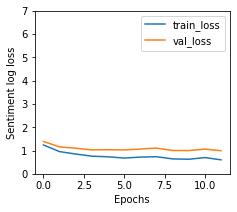

CPU times: user 1min 46s, sys: 979 ms, total: 1min 47s
Wall time: 1min 48s


In [9]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden,    nhidden,   dtype=torch.float64, requires_grad=True)
U = torch.randn(nhidden,  nfeatures, dtype=torch.float64, requires_grad=True) # embed one-hot char vec
V = torch.randn(nclasses, nhidden,   dtype=torch.float64, requires_grad=True) # take RNN output (h) and predict target

optimizer = torch.optim.Adam([W,U,V], lr=0.005, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    for p in range(0, n, batch_size):  # do one epoch
        loss = 0
        for i in range(p, p+batch_size): # do one batch
            x = X_train[i]
            h = torch.zeros(nhidden, 1, dtype=torch.float64, requires_grad=False)  # reset hidden state at start of record
            for j in range(len(x)):  # for each char in a name
                h = W.mm(h) + U.mm(onehot(x[j]))
                h = torch.tanh(h)
            # h is output of RNN, a fancy CBOW embedding for variable-length sequence in x
            # run through a final layer to map that h to a one-hot encoded predicted class
#             h = dropout(h, p=0.3)
            o = V.mm(h)
            o = o.reshape(1,nclasses)
            o = softmax(o)
            loss += cross_entropy(o, y_train[i])
            correct = torch.argmax(o[0])==y_train[i]
            epoch_training_accur += correct

        # update matrices based upon loss computed from a batch
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

#         print(loss.detach().item())
        epoch_training_loss += loss.detach().item()

    epoch_training_loss /= n
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train)
        correct = torch.argmax(o, dim=1).detach()==y_train
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid)
        valid_loss = cross_entropy(o, y_valid)
        correct = torch.argmax(o, dim=1).detach()==y_valid
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

Timing on 80% training from full data set:

```
CPU times: user 1min 46s, sys: 979 ms, total: 1min 47s
Wall time: 1min 48s
```